In [182]:
%matplotlib inline

import os
import pandas as pd
import contextily as ctx
import geopandas as gpd
import plotly.graph_objects as go
import pycountry
import plotly.express as px
import matplotlib.pyplot as plt

In [110]:
data_path = '../Data/data/'
hifld_path = data_path + 'hifld/hifld/'
county_health_p = data_path + 'county_health_rankings/county_health_rankings/us-county-health-rankings-2020.csv'
facilities_p = data_path + 'esri_covid-19/esri_covid-19/cdphe-health-facilities.csv'
vulnerable_p = data_path + 'esri_covid-19/esri_covid-19/cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv'
nyt_cases_p = data_path + 'New_York_Times/covid-19-county-level-data.csv'
usaf_cases_p = data_path + 'USAFacts/confirmed-covid-19-cases-in-us-by-state-and-county.csv'

In [111]:
facilities = pd.read_csv(facilities_p)
facilities.head()

geometry  objectid  \
0      POINT (-104.632767 38.268394)      3001   
1      POINT (-104.671387 38.228497)      3002   
2  POINT (-104.668221 38.2281569999)      3003   
3  POINT (-104.665939 38.2268829999)      3004   
4  POINT (-104.660072 38.2318499997)      3005   

                                            fac_name  \
0  HUMAN TOUCH UNSKILLED SERVICES PUEBLO INC (04L...   
1                       BROOKDALE EL CAMINO (2306MT)   
2                            GOLDEN HORIZON (230663)   
3                LIFE CARE CENTER OF PUEBLO (020641)   
4              PUEBLO COMMUNITY CONNECTIONS (10F366)   

                                        name               address  \
0  HUMAN TOUCH UNSKILLED SERVICES PUEBLO INC   1008 W ABRIENDO AVE   
1                        BROOKDALE EL CAMINO    4723 SURFWOOD LANE   
2                             GOLDEN HORIZON         2109 CHAUTARD   
3                 LIFE CARE CENTER OF PUEBLO      2118 CHATALET LN   
4               PUEBLO COMMUNITY CONNECTIONS  3913 SANDLEWOOD LANE   

         city_state    city state    zip  operating  ...  date_geoco  \
0  PUEBLO, CO 81004  PUEBLO    CO  81004  01-ACTIVE  ...  2020-03-01   
1  PUEBLO, CO 81005  PUEBLO    CO  81005  01-ACTIVE  ...  2020-03-01   
2  PUEBLO, CO 81005  PUEBLO    CO  81005  01-ACTIVE  ...  2020-03-01   
3  PUEBLO, CO 81005  PUEBLO    CO  81005  01-ACTIVE  ...  2020-03-01   
4  PUEBLO, CO 81005  PUEBLO    CO  81005  01-ACTIVE  ...  2020-03-01   

                                              source   geo_tract  geo_county  \
0  CDPHE Health Facilities and Emergency Medical ...  8101001500      PUEBLO   
1  CDPHE Health Facilities and Emergency Medical ...  8101002801      PUEBLO   
2  CDPHE Health Facilities and Emergency Medical ...  8101002801      PUEBLO   
3  CDPHE Health Facilities and Emergency Medical ...  8101002801      PUEBLO   
4  CDPHE Health Facilities and Emergency Medical ...  8101002700      PUEBLO   

  geo_zip                                            factype  \
0   81004        Home Care Agency - In-Home Support Services   
1   81005                          Assisted Living Residence   
2   81005                          Assisted Living Residence   
3   81005                                       Nursing Home   
4   81005  Home and Community Based Services - Intellectu...   

                                   symbol   latitude   longitude      type  
0                             Home Health  38.268394 -104.632767  HCA-IHSS  
1  Assisted Living Residence/Nursing Home  38.228497 -104.671387   ALRONLY  
2  Assisted Living Residence/Nursing Home  38.228157 -104.668221   ALR/ACF  
3  Assisted Living Residence/Nursing Home  38.226883 -104.665939    SNF/NF  
4       Home and Community Based Services  38.231850 -104.660072  HCBS-IDD  

[5 rows x 32 columns]

In [269]:
facilities_cols=['geometry','fac_name','state','county','symbol','medicare','medicaid']
bool_map = {'t':True, 'f':False}
fac_subset = facilities[facilities_cols]
fac_subset['medicare'] = fac_subset['medicare'].replace(bool_map)
fac_subset['medicaid'] = fac_subset['medicaid'].replace(bool_map)
fac_subset.head()

/Users/jahnavisingh/anaconda3/envs/PH244/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jahnavisingh/anaconda3/envs/PH244/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



geometry  \
0      POINT (-104.632767 38.268394)   
1      POINT (-104.671387 38.228497)   
2  POINT (-104.668221 38.2281569999)   
3  POINT (-104.665939 38.2268829999)   
4  POINT (-104.660072 38.2318499997)   

                                            fac_name state  county  \
0  HUMAN TOUCH UNSKILLED SERVICES PUEBLO INC (04L...    CO  PUEBLO   
1                       BROOKDALE EL CAMINO (2306MT)    CO  PUEBLO   
2                            GOLDEN HORIZON (230663)    CO  PUEBLO   
3                LIFE CARE CENTER OF PUEBLO (020641)    CO  PUEBLO   
4              PUEBLO COMMUNITY CONNECTIONS (10F366)    CO  PUEBLO   

                                   symbol  medicare  medicaid  
0                             Home Health     False     False  
1  Assisted Living Residence/Nursing Home     False     False  
2  Assisted Living Residence/Nursing Home     False      True  
3  Assisted Living Residence/Nursing Home      True      True  
4       Home and Community Based Services     False     False

In [146]:
def coverage_percentage(col):
    medicare_percentage = sum(col['medicare']) / col['medicare'].shape[0]
    medicaid_percentage = sum(col['medicaid']) / col['medicaid'].shape[0]
    return medicare_percentage, medicaid_percentage

In [280]:
# medicare_aid = fac_subset.groupby('county')[['medicare', 'medicaid']].mean().reset_index()
# medicare_aid['county'] = medicare_aid['county'].str.lower()
# medicare_aid.head()
medicare_aid = fac_subset.groupby(['state','county'])[['medicare', 'medicaid']].agg(['count', 'mean']).reset_index()
medicare_aid['county'] = medicare_aid['county'].str.lower()
medicare_aid.columns = medicare_aid.columns.to_flat_index()
medicare_aid.columns = ['state','county', 'count', 'medicare', 'count2', 'medicaid']
medicare_aid = medicare_aid.drop(columns='count2')
medicare_aid.head()

state     county  count  medicare  medicaid
0    CO      adams    387  0.224806  0.186047
1    CO    alamosa     24  0.500000  0.375000
2    CO   arapahoe    746  0.182306  0.227882
3    CO  archuleta      6  0.500000  0.333333
4    CO       baca     10  0.700000  0.700000

In [354]:
nyt_cases = pd.read_csv(nyt_cases_p)
# Removing unknown counties for states that have more than 1 unknown county
counties_per_state = nyt_cases.groupby('state')['county'].apply(lambda x: len(set(x)))
single_county_states = counties_per_state[counties_per_state == 1].index.to_list()
nyt_cases = nyt_cases[(nyt_cases['county'] != 'Unknown') | 
                      (nyt_cases['state'].isin(single_county_states))]
# CONFIRM: Taking max of each county's data
county_cases = nyt_cases.groupby(['state','county'])[['cases', 'deaths']].max().reset_index()
county_cases['county'] = county_cases['county'].str.lower()
county_cases.describe()

cases       deaths
count   2405.000000  2405.000000
mean     127.016632     3.380457
std     1422.879956    48.354680
min        0.000000     0.000000
25%        2.000000     0.000000
50%        7.000000     0.000000
75%       28.000000     1.000000
max    63307.000000  2254.000000

In [338]:
# Map states abbreviations to state names
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [344]:
medicare_aid['state'] = medicare_aid['state'].replace(states)

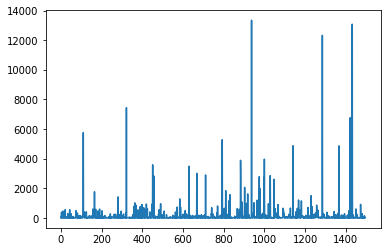

In [234]:
county_cases[~(county_cases['county']=='new york city')]['cases'].plot()

In [176]:
# Counties whose medicare/aid information we have, but not COVID-19 statistics
inter_counties = set(medicare_aid['county']).intersection(set(county_cases['county']))
medicare_aid[~medicare_aid['county'].isin(inter_counties)]

county  medicare  medicaid
5       bent  0.571429  0.428571
9   cheyenne  0.800000  0.400000
10   conejos  0.833333  0.500000
22    gilpin  1.000000  0.000000
47   prowers  0.600000  0.350000

In [358]:
county_cases[county_cases['state'] == 'Colorado'].describe()

cases     deaths
count   54.000000  54.000000
mean    80.796296   2.333333
std    165.150289   5.150563
min      1.000000   0.000000
25%      3.000000   0.000000
50%      7.000000   0.000000
75%     42.000000   1.750000
max    769.000000  22.000000

In [346]:
# Merge county cases and medicare data by state and county
county_cases_medicare_aid = county_cases.merge(medicare_aid, left_on=['state','county'], 
                                               right_on=['state','county'])
county_cases_medicare_aid.shape

(52, 7)

In [348]:
county_cases_medicare_aid.describe()

cases     deaths       count   medicare   medicaid
count   52.000000  52.000000   52.000000  52.000000  52.000000
mean    83.750000   2.423077   67.846154   0.481753   0.437865
std    167.642111   5.229427  137.493014   0.215019   0.221411
min      1.000000   0.000000    1.000000   0.182306   0.000000
25%      3.000000   0.000000    5.750000   0.320060   0.311298
50%      8.500000   0.000000   13.000000   0.425824   0.375000
75%     43.250000   2.000000   33.750000   0.562500   0.578571
max    769.000000  22.000000  746.000000   1.000000   1.000000

In [351]:
county_cases_medicare_aid[county_cases_medicare_aid['count'] <= 33].describe()

cases     deaths      count   medicare   medicaid
count   39.000000  39.000000  39.000000  39.000000  39.000000
mean    20.051282   0.435897  10.923077   0.545825   0.477720
std     54.369568   0.967767   8.367810   0.210188   0.239013
min      1.000000   0.000000   1.000000   0.238095   0.000000
25%      2.000000   0.000000   3.500000   0.403704   0.333333
50%      4.000000   0.000000   9.000000   0.500000   0.428571
75%     13.500000   0.500000  15.000000   0.677083   0.666667
max    333.000000   5.000000  31.000000   1.000000   1.000000

In [353]:
county_cases_medicare_aid[county_cases_medicare_aid['count'] > 33]

state     county  cases  deaths  count  medicare  medicaid
0   Colorado      adams    320       9    387  0.224806  0.186047
2   Colorado   arapahoe    552      10    746  0.182306  0.227882
5   Colorado    boulder    159       3    170  0.311765  0.282353
12  Colorado     denver    769      14    299  0.284281  0.344482
13  Colorado    douglas    209       3    126  0.261905  0.198413
15  Colorado    el paso    406      22    382  0.301047  0.248691
17  Colorado    fremont      3       0     43  0.418605  0.441860
18  Colorado   garfield     45       1     42  0.285714  0.404762
23  Colorado  jefferson    483      15    352  0.250000  0.357955
27  Colorado    larimer    144       8    196  0.331633  0.377551
31  Colorado       mesa     20       0    114  0.280702  0.394737
41  Colorado     pueblo     39       2    143  0.307692  0.349650
50  Colorado       weld    424      22    102  0.323529  0.323529

In [245]:
county_cases_medicare_aid[county_cases_medicare_aid['count'] <= 12].describe()

cases     deaths      count   medicare   medicaid
count   28.000000  28.000000  28.000000  28.000000  28.000000
mean    59.750000   1.321429   5.500000   0.618449   0.504682
std    139.949363   2.944594   3.543382   0.231233   0.279256
min      1.000000   0.000000   1.000000   0.250000   0.000000
25%      2.750000   0.000000   3.000000   0.479167   0.333333
50%      5.500000   0.000000   5.000000   0.591667   0.550000
75%     39.500000   1.000000   8.250000   0.739899   0.666667
max    689.000000  14.000000  12.000000   1.000000   1.000000

In [236]:
county_cases_medicare_aid[county_cases_medicare_aid['deaths'] <= 1][['medicare', 'medicaid', 'count']].describe()

medicare   medicaid       count
count  37.000000  37.000000   37.000000
mean    0.513412   0.467360   15.702703
std     0.192849   0.202052   19.878611
min     0.238095   0.000000    1.000000
25%     0.333333   0.346154    5.000000
50%     0.500000   0.428571    9.000000
75%     0.625000   0.666667   21.000000
max     1.000000   0.888889  114.000000

In [239]:
county_cases_medicare_aid[county_cases_medicare_aid['deaths'] > 1][['county', 'count']]

county  count
0        adams    387
2     arapahoe    746
5      boulder    170
6   broomfield      5
7      chaffee     13
12      denver    299
13     douglas    126
14       eagle     16
15     el paso    382
23     jackson      1
24   jefferson    352
28        lake      1
29     larimer    196
42      pitkin      2
43      pueblo    143
50      summit     12
52  washington      3
53        weld    102

In [237]:
county_cases_medicare_aid[county_cases_medicare_aid['deaths'] > 1][['medicare', 'medicaid', 'count']].describe()

medicare   medicaid       count
count  18.000000  18.000000   18.000000
mean    0.462311   0.374630  164.222222
std     0.275669   0.265315  202.154151
min     0.182306   0.000000    1.000000
25%     0.288472   0.233084    6.750000
50%     0.327581   0.328431  114.000000
75%     0.528846   0.372652  273.250000
max     1.000000   1.000000  746.000000

In [246]:
county_cases_medicare_aid.describe()

cases     deaths       count   medicare   medicaid
count    55.000000  55.000000   55.000000  55.000000  55.000000
mean    151.745455   4.327273   64.309091   0.496688   0.437012
std     429.600297  13.437171  134.443692   0.222043   0.226507
min       1.000000   0.000000    1.000000   0.182306   0.000000
25%       4.000000   0.000000    5.000000   0.323055   0.310096
50%      20.000000   1.000000   12.000000   0.437500   0.375000
75%     116.000000   2.500000   30.000000   0.612500   0.600000
max    3008.000000  95.000000  746.000000   1.000000   1.000000

In [261]:
county_health = pd.read_csv(county_health_p)
county_health['county'] = county_health['county'].str.lower()
county_health = county_health.dropna(subset=['county'])
county_health.head()

fips    state   county  num_deaths  years_of_potential_life_lost_rate  \
1  1001  Alabama  autauga       791.0                        8128.591190   
2  1003  Alabama  baldwin      2967.0                        7354.122530   
3  1005  Alabama  barbour       472.0                       10253.573403   
4  1007  Alabama     bibb       471.0                       11977.539484   
5  1009  Alabama   blount      1085.0                       11335.071134   

   95percent_ci_low  95percent_ci_high  quartile  ypll_rate_aian  \
1       7283.340731        8973.841649       1.0             NaN   
2       6918.554269        7789.690790       1.0             NaN   
3       8782.217281       11724.929524       2.0             NaN   
4      10344.064842       13611.014126       3.0             NaN   
5      10288.871387       12381.270881       3.0             NaN   

   ypll_rate_aian_95percent_ci_low  ...  percent_hispanic  \
1                              NaN  ...          2.965774   
2                              NaN  ...          4.646779   
3                              NaN  ...          4.276355   
4                              NaN  ...          2.625000   
5                              NaN  ...          9.571231   

   num_non_hispanic_white  percent_non_hispanic_white  \
1                   41316                   74.308016   
2                  181201                   83.111337   
3                   11356                   45.641252   
4                   16708                   74.589286   
5                   50255                   86.886238   

   num_not_proficient_in_english  percent_not_proficient_in_english  \
1                            426                           0.820225   
2                           1068                           0.543517   
3                            398                           1.631683   
4                             57                           0.268210   
5                            934                           1.724520   

   95percent_ci_low_39  95percent_ci_high_39  percent_female  num_rural  \
1             0.347891              1.292558       51.448715    22921.0   
2             0.347271              0.739763       51.538377    77060.0   
3             0.824903              2.438462       47.216752    18613.0   
4             0.000000              0.807504       46.781250    15663.0   
5             1.198129              2.250911       50.726141    51562.0   

   percent_rural  
1      42.002162  
2      42.279099  
3      67.789635  
4      68.352607  
5      89.951502  

[5 rows x 507 columns]

In [263]:
county_health_cols = ['state', 'county', 'num_deaths', 'percent_adults_with_obesity', 'percent_rural',
                      'percent_smokers', 'average_number_of_physically_unhealthy_days',
                      'percent_fair_or_poor_health', 'ypll_rate_hispanic', 'ypll_rate_black']
county_health_sub = county_health[county_health_cols]
county_health_sub.head()

state   county  num_deaths  percent_adults_with_obesity  percent_rural  \
1  Alabama  autauga       791.0                         33.3      42.002162   
2  Alabama  baldwin      2967.0                         31.0      42.279099   
3  Alabama  barbour       472.0                         41.7      67.789635   
4  Alabama     bibb       471.0                         37.6      68.352607   
5  Alabama   blount      1085.0                         33.8      89.951502   

   percent_smokers  average_number_of_physically_unhealthy_days  \
1        18.081557                                     4.743889   
2        17.489033                                     4.224519   
3        21.999985                                     5.430279   
4        19.114200                                     4.591482   
5        19.208672                                     4.860808   

   percent_fair_or_poor_health  ypll_rate_hispanic  ypll_rate_black  
1                    20.882987                 NaN     10201.389930  
2                    17.509134         3570.475265      9890.505276  
3                    29.591802                 NaN     12422.166370  
4                    19.439724                 NaN     13085.045008  
5                    21.745293                 NaN              NaN

In [384]:
county_health['percent_adults_with_obesity'].describe()

count    3142.000000
mean       32.857352
std         5.451913
min        12.400000
25%        29.200000
50%        33.100000
75%        36.500000
max        57.700000
Name: percent_adults_with_obesity, dtype: float64

In [368]:
# Merge county cases and medicare data by state and county
colo_county_cases_health = county_health_sub.merge(county_cases_medicare_aid, left_on=['state','county'], 
                                               right_on=['state','county'])
colo_county_cases_health.shape

(52, 15)

In [382]:
colo_county_cases_health[colo_county_cases_health['percent_adults_with_obesity'] >= 24].describe()




num_deaths  percent_adults_with_obesity  percent_rural  \
count    22.000000                    28.000000      28.000000   
mean    648.000000                    28.971429      62.838938   
std    1158.994926                     3.246634      33.746046   
min      61.000000                    24.000000       3.620446   
25%      94.000000                    27.150000      32.177248   
50%     213.500000                    27.950000      62.853739   
75%     357.000000                    30.825000     100.000000   
max    4658.000000                    38.000000     100.000000   

       percent_smokers  average_number_of_physically_unhealthy_days  \
count        28.000000                                    28.000000   
mean         14.951369                                     3.707165   
std           1.557764                                     0.415264   
min          12.290956                                     2.970990   
25%          14.026486                                     3.445874   
50%          14.691227                                     3.622696   
75%          15.981545                                     3.914017   
max          18.629093                                     4.794077   

       percent_fair_or_poor_health  ypll_rate_hispanic  ypll_rate_black  \
count                    28.000000            8.000000         2.000000   
mean                     16.454546        10146.928476     11115.523532   
std                       3.824207         4404.593665      2871.026474   
min                      10.793961         5453.691011      9085.401243   
25%                      13.620473         5770.478373     10100.462387   
50%                      15.636202        10515.725919     11115.523532   
75%                      17.677548        12244.699066     12130.584677   
max                      27.970708        17941.509699     13145.645821   

            cases     deaths       count   medicare   medicaid  
count   28.000000  28.000000   28.000000  28.000000  28.000000  
mean    31.500000   1.285714   34.000000   0.533702   0.485077  
std     97.486751   4.412584   75.810192   0.234091   0.223777  
min      1.000000   0.000000    1.000000   0.224806   0.000000  
25%      1.750000   0.000000    4.750000   0.330882   0.342949  
50%      3.000000   0.000000   10.500000   0.500000   0.435216  
75%      6.500000   0.000000   24.500000   0.703571   0.666667  
max    424.000000  22.000000  387.000000   1.000000   1.000000

## Initial EDA of Geospatial Data

In [5]:
us_air = pd.read_csv(hifld_path + 'aircraft-landing-facilities.csv')
us_air.head()

/Users/jahnavisingh/anaconda3/envs/PH244/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (49,50,51,56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


geometry  objectid   sitenumber      type  \
0  POINT (-105.161729395 40.1124574763)      3001  02695.351*H  HELIPORT   
1  POINT (-108.283929396 38.0999574774)      3002   02695.41*H  HELIPORT   
2  POINT (-108.184029397 38.2999574768)      3003   02695.42*H  HELIPORT   
3  POINT (-108.340429395 38.1624574774)      3004    02695.5*A   AIRPORT   
4  POINT (-108.213129398 38.2193574758)      3005   02695.51*A   AIRPORT   

  locationid                effectived region districtof state statename  ...  \
0       85CO  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...   
1       CD55  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...   
2       CD54  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...   
3       1CO2  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...   
4       0CO6  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...   

  airporte_1 contractfu transients otherservi windindica icaoidenti  \
0        NaN        NaN        NaN        NaN        Y-L        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN          Y        NaN   
4        NaN        NaN        NaN        NaN          Y        NaN   

    longitude latitude_d enplanemen passengers  
0 -105.161652  40.112484          0          0  
1 -108.283913  38.099998          0          0  
2 -108.183968  38.299988          0          0  
3 -108.340363  38.162491          0          0  
4 -108.213135  38.219433          0          0  

[5 rows x 108 columns]

In [15]:
gdf = gpd.GeoDataFrame(
    us_air, geometry=gpd.points_from_xy(us_air.longitude, us_air.latitude_d))
gdf.head()

geometry  objectid   sitenumber      type locationid  \
0  POINT (-105.16165 40.11248)      3001  02695.351*H  HELIPORT       85CO   
1  POINT (-108.28391 38.10000)      3002   02695.41*H  HELIPORT       CD55   
2  POINT (-108.18397 38.29999)      3003   02695.42*H  HELIPORT       CD54   
3  POINT (-108.34036 38.16249)      3004    02695.5*A   AIRPORT       1CO2   
4  POINT (-108.21314 38.21943)      3005   02695.51*A   AIRPORT       0CO6   

                 effectived region districtof state statename  ... airporte_1  \
0  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...        NaN   
1  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...        NaN   
2  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...        NaN   
3  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...        NaN   
4  2017-06-22T00:00:00.000Z    ANM        DEN    CO  COLORADO  ...        NaN   

  contractfu transients otherservi windindica icaoidenti   longitude  \
0        NaN        NaN        NaN        Y-L        NaN -105.161652   
1        NaN        NaN        NaN        NaN        NaN -108.283913   
2        NaN        NaN        NaN        NaN        NaN -108.183968   
3        NaN        NaN        NaN          Y        NaN -108.340363   
4        NaN        NaN        NaN          Y        NaN -108.213135   

  latitude_d enplanemen passengers  
0  40.112484          0          0  
1  38.099998          0          0  
2  38.299988          0          0  
3  38.162491          0          0  
4  38.219433          0          0  

[5 rows x 108 columns]

In [54]:
fig = px.density_mapbox(gdf, 
                        lat="latitude_d", 
                        lon="longitude", 
                        hover_name="districtof", 
                        hover_data=["passengers"], 
#                         animation_frame="Date",
                        color_continuous_scale="Portland",
                        radius=7, 
                        zoom=0,height=700)
fig.update_layout(title='Worldwide Corona Virus Cases Time Lapse - Confirmed, Deaths, Recovered',
                  font=dict(family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f")
                 )
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=0)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

AttributeError: 'GeoDataFrame' object has no attribute 'set_aspect'

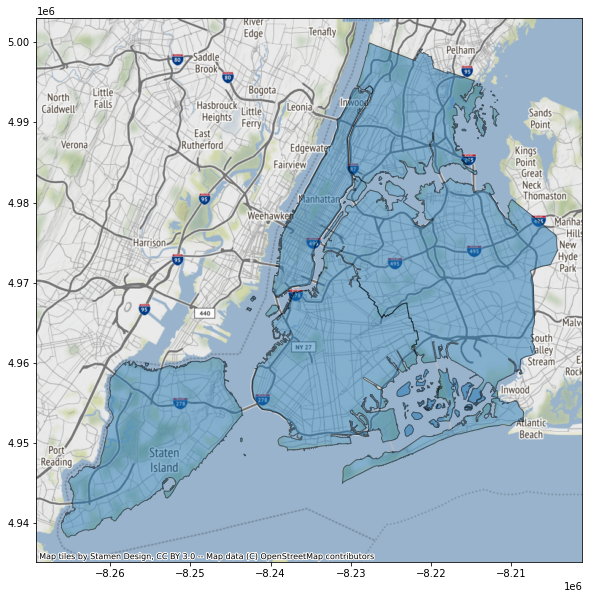

In [46]:
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc = nyc.to_crs(epsg=3857)
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=10);

/Users/jahnavisingh/anaconda3/envs/PH244/lib/python3.7/site-packages/geopandas/plotting.py:509: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


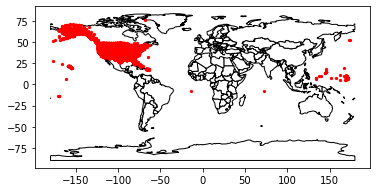

In [32]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')

gdf.plot(ax=base, marker='o', color='red', markersize=5, column='trafficpat');

In [55]:
us_hosp = pd.read_csv(hifld_path + 'hospitals.csv')
us_hosp.head()

geometry  objectid        id  \
0  POINT (-71.049055546 42.378509076)     14510  10602129   
1  POINT (-70.468102837 41.732984497)     14511  12602537   
2            POINT (-70.9799 42.5018)     14512   3201904   
3             POINT (-71.2021 42.189)     14513   4002062   
4            POINT (-70.9915 42.0879)     14514   2502302   

                                         name               address      city  \
0           SPAULDING REHABILITATION HOSPITAL           300 1ST AVE    BOSTON   
1  SPAULDING REHABILITATION HOSPITAL CAPE COD      311 SERVICE ROAD  SANDWICH   
2   NORTH SHORE MEDICAL CENTER - UNION CAMPUS  500 LYNNFIELD STREET      LYNN   
3                            NORWOOD HOSPITAL   800 WASHINGTON ROAD   NORWOOD   
4      SIGNATURE HEALTHCARE BROCKTON HOSPITAL     680 CENTRE STREET  BROCKTON   

  state   zip           zip4       telephone  ...                  val_date  \
0    MA  2129  NOT AVAILABLE  (617) 573-7000  ...  2018-03-19T00:00:00.000Z   
1    MA  2537  NOT AVAILABLE  (508) 833-4000  ...  2018-03-19T00:00:00.000Z   
2    MA  1904  NOT AVAILABLE  (781) 581-9200  ...  2018-03-19T00:00:00.000Z   
3    MA  2062  NOT AVAILABLE  (781) 769-4000  ...  2018-03-19T00:00:00.000Z   
4    MA  2302  NOT AVAILABLE  (508) 941-7000  ...  2018-03-19T00:00:00.000Z   

                                             website  state_id  \
0                         http://spauldingrehab.org/      2321   
1   http://spauldingrehab.org/locations/sandwich-ma/      2FXY   
2  http://nsmc.partners.org/locations/union_hospital      2008   
3                  https://www.norwood-hospital.org/      2114   
4                http://www.signature-healthcare.org      2118   

              alt_name st_fips        owner  ttl_staff  beds         trauma  \
0        NOT AVAILABLE      25   NON-PROFIT       -999   132  NOT AVAILABLE   
1        NOT AVAILABLE      25   NON-PROFIT       -999    60  NOT AVAILABLE   
2  NSMC UNION HOSPITAL      25   NON-PROFIT       -999  -999  NOT AVAILABLE   
3     NORWOOD HOSPITAL      25  PROPRIETARY       -999   215  NOT AVAILABLE   
4    BROCKTON HOSPITAL      25   NON-PROFIT       -999   197  NOT AVAILABLE   

         helipad  
0  NOT AVAILABLE  
1              N  
2  NOT AVAILABLE  
3              Y  
4  NOT AVAILABLE  

[5 rows x 33 columns]

In [59]:
us_phd = pd.read_csv(hifld_path + 'public-health-departments.csv')
us_phd.head()

geometry  objectid        id  \
0  POINT (-122.379594062 40.5498129414)      1001  11613145   
1    POINT (-121.7849395 42.2241672379)      1002  11616735   
2  POINT (-92.7213797529 35.1669456627)      1003  11616453   
3  POINT (-119.146872135 34.2179901368)      1004  11613155   
4    POINT (-96.932332771 29.448233204)      1005  11616973   

                                                name     telephone  \
0             SHASTA COUNTY PUBLIC HEALTH DEPARTMENT  530-225-5591   
1                   KLAMATH COUNTY HEALTH DEPARTMENT  541-882-8846   
2              CONWAY COUNTY HEALTH UNIT - MORRILTON  501-354-4652   
3            VENTURA COUNTY PUBLIC HEALTH DEPARTMENT  805-981-5172   
4  TEXAS DEPARTMENT OF STATE HEALTH SERVICES - HA...  361-798-4371   

                   address address2           city state    zip  ...  \
0       2650 BRESLAUER WAY      NaN        REDDING    CA  96001  ...   
1          403 PINE STREET      NaN  KLAMATH FALLS    OR  97601  ...   
2       100 HOSPITAL DRIVE      NaN      MORRILTON    AR  72110  ...   
3  2240 EAST GONZALES ROAD      NaN         OXNARD    CA  93036  ...   
4  1309 EAST CEMETERY ROAD      NaN  HALLETTSVILLE    TX  77964  ...   

   phoneloc           qc_qa  \
0       YES  TECHNIGRAPHICS   
1       YES  TECHNIGRAPHICS   
2       YES  TECHNIGRAPHICS   
3       YES  TECHNIGRAPHICS   
4       YES  TECHNIGRAPHICS   

                                             website  fcode gnis_id  \
0  HTTP://WWW.CO.SHASTA.CA.US/HTML/PUBLIC_HEALTH/...  80028     NaN   
1   HTTP://WWW.CO.KLAMATH.OR.US/HEALTHDEPT/INDEX.HTM  80028     NaN   
2  HTTP://WWW.HEALTHYARKANSAS.COM/UNITS/NWN.PHP#C...  80028     NaN   
3                  HTTP://WWW.VCHCA.ORG/PH/INDEX.HTM  80028     NaN   
4                                                NaN  80028     NaN   

           source  govt_level tot_staff spec_equip sdr  
0  TECHNIGRAPHICS       LOCAL         0        NaN   t  
1  TECHNIGRAPHICS       LOCAL         0        NaN   t  
2     ARGIO/ARDOH       LOCAL         0        NaN   t  
3  TECHNIGRAPHICS       LOCAL         0        NaN   t  
4  TECHNIGRAPHICS       LOCAL         0        NaN   t  

[5 rows x 40 columns]

In [60]:
us_ucf = pd.read_csv(hifld_path + 'urgent-care-facilities.csv')
us_ucf.head()

geometry  objectid        id  \
0  POINT (-84.1615716333 35.8801187098)      4001  11513140   
1  POINT (-84.4223299591 39.1639540845)      4002  10422042   
2  POINT (-81.6321559925 30.1449766385)      4003  10425970   
3  POINT (-76.9569441354 40.2053115101)      4004  10844061   
4  POINT (-66.2613407982 18.1431536025)      4005  11513174   

                                      name     telephone  \
0                  FARRAGUT WALK-IN CLINIC  865-671-6026   
1           TRISTATE URGENT CARE OF OAKLEY  513-531-1505   
2  SOLANTIC WALK-IN URGENT CARE - MANDARIN  904-288-0277   
3  CONCENTRA URGENT CARE - HARRISBURG WEST  717-795-1819   
4              EL CENTRO HERIDAS Y ULCERAS  787-735-8001   

                    address address2           city state    zip  ...  \
0       11408 KINGSTON PIKE      NaN      KNOXVILLE    TN  37934  ...   
1         5002 RIDGE AVENUE      NaN     CINCINNATI    OH  45209  ...   
2  12303 SAN JOSE BOULEVARD      NaN   JACKSONVILLE    FL  32223  ...   
3          4910 RITTER ROAD      NaN  MECHANICSBURG    PA  17055  ...   
4      CALLE JOSE C VAZQUEZ      NaN       AIBONITO    PR    705  ...   

                                          naicsdescr    geolinkid          x  \
0  URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...   24657452.0 -84.161572   
1  URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...   32010448.0 -84.422330   
2  URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...   23055221.0 -81.632156   
3  URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...   43026986.0 -76.956944   
4  URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...  120166426.0 -66.261341   

           y  st_vendor st_version    geoprec phoneloc qc_qa ucaoa_id  
0  35.880119     NAVTEQ     2008Q1   ONENTITY        t   TGS      NaN  
1  39.163954     NAVTEQ     2008Q1   ONENTITY        t   TGS  UC_3004  
2  30.144977     NAVTEQ     2008Q1  BLOCKFACE        t   TGS      NaN  
3  40.205312     NAVTEQ     2008Q1   ONENTITY        t   TGS      NaN  
4  18.143154     NAVTEQ     2008Q1   ONENTITY        f   TGS      NaN  

[5 rows x 33 columns]

In [88]:
air_counties = us_air.groupby('county')['type'].count().reset_index().rename(columns={'type':'count'})

In [89]:
ucf_counties = us_ucf.groupby('county')['zip'].count().reset_index().rename(columns={'zip':'count'})
ucf_counties.shape

(882, 2)

In [86]:
phd_counties = us_phd.groupby('county')['zip'].count().reset_index().rename(columns={'zip':'count'})

In [90]:
hosp_counties = us_hosp.groupby('county')['zip'].count().reset_index().rename(columns={'zip':'count'})
hosp_counties.shape

(1602, 2)

In [92]:
ucf_hosp_count = ucf_counties.merge(hosp_counties, left_on='county', right_on='county', how='outer', 
                                    suffixes=('_left', '_right'))
ucf_hosp_count.head()

county  count_left  count_right
0        ADA        15.0         11.0
1      ADAIR         2.0          4.0
2      ADAMS         9.0         20.0
3  AGUADILLA         1.0          1.0
4   AIBONITO         1.0          1.0

In [99]:
ucf_hosp_count['tot_count'] = ucf_hosp_count['count_left'] + ucf_hosp_count['count_right']
ucf_hosp_count[['county', 'tot_count']].head()

county  tot_count
0        ADA       26.0
1      ADAIR        6.0
2      ADAMS       29.0
3  AGUADILLA        2.0
4   AIBONITO        2.0

In [107]:
phd_counties[phd_counties['count'] > 10]

county  count
6        ADDISON     23
81    BARNSTABLE     16
112   BENNINGTON     17
117       BERGEN     13
120    BERKSHIRE     30
169      BRISTOL     21
209      CALHOUN     11
228      CARROLL     12
280   CHITTENDEN     11
293        CLARK     11
296         CLAY     17
339         COOK     12
357     CRAWFORD     11
433      DOUGLAS     11
479        ESSEX     61
486    FAIRFIELD     22
512     FRANKLIN     58
569        GRANT     13
579       GREENE     14
606     HAMILTON     14
608      HAMPDEN     23
609    HAMPSHIRE     19
632     HARTFORD     15
712      JACKSON     26
716    JEFFERSON     29
789         LAKE     13
792     LAMOILLE     11
812     LAWRENCE     13
819          LEE     12
836      LINCOLN     21
868      MADISON     20
882       MARION     18
886     MARSHALL     12
928       MERCER     14
936    MIDDLESEX     70
944    MILWAUKEE     13
961       MONROE     17
965   MONTGOMERY     21
972       MORGAN     11
973       MORRIS     18
1005   NEW HAVEN     15
1007  NEW LONDON     12
1023     NORFOLK     30
1060      ORANGE     25
1063     ORLEANS     21
1110       PERRY     11
1121        PIKE     11
1135    PLYMOUTH     28
1139        POLK     12
1168     PULASKI     13
1233     RUTLAND     25
1281       SCOTT     11
1471       UNION     26
1512      WARREN     13
1519  WASHINGTON     51
1527       WAYNE     17
1562     WINDHAM     24
1563     WINDSOR     26
1578   WORCESTER     62

In [104]:
phd_counties['count'].value_counts()

1     1103
2      259
3       76
4       45
5       17
7       13
6       10
11      10
9        9
13       7
8        7
10       7
12       6
17       4
21       4
14       3
26       3
18       2
15       2
23       2
30       2
25       2
20       1
29       1
61       1
58       1
51       1
24       1
28       1
19       1
22       1
16       1
62       1
70       1
Name: count, dtype: int64